## Klassifikation menschlicher Aktivitäten mittels klassischer Machine-Learning-Modelle


In diesem Teil des Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten eingesetzt, um menschliche Aktivitäten zu klassifizieren – konkret: Gehen (walk), Laufen (run), Sitzen (sitting) und Bergaufgehen (climbing).

Die untersuchten Algorithmen sind:

* Random Forest
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Ziel der Analyse ist es, die drei Modelle anhand etablierter Leistungskennzahlen – Accuracy, Precision, Recall und F1-Score – systematisch zu vergleichen und dabei eine Klassifikationsgenauigkeit von mindestens 90 % zu erreichen.

 **Struktur des Notebooks**

 1. Vorbereitung & Datenexploration

 2. Training jedes Modells + Feature‑Importance

 3. Konsolidierter Modellvergleich

### Teil 1: Vorbereitung

Im ersten Schritt bereite ich die Daten für das Trainieren unserer Modelle vor. Ziel ist es, eine saubere und konsistente Eingabematrix für die Klassifikation zu erzeugen. Dazu zählen das Einlesen der vorverarbeiteten Zeitfensterdaten, die Aufteilung in Trainings- und Testdatensatz sowie eine Standardisierung der Eingabefeatures. Zustätzlich befinden sich in diesem Teil alle imports für dieses Notebook.

In [221]:
import sys
import os
import pandas as pd
import rootutils
import numpy as np

np.random.seed(123)

root = rootutils.setup_root(search_from=".", indicator=".git")

DATA_DIR_TRAIN = root / "data" / "NDL" / "TRAIN"
DATA_DIR_TEST = root / "data" / "NDL" / "TEST"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import utils

In [222]:
df_train = pd.read_csv(DATA_DIR_TRAIN / "features_non_dl.csv")
df_test = pd.read_csv(DATA_DIR_TEST / "features_non_dl.csv")
df_train.head(2)
df_test.head(2)

,seconds_elapsed_mean,seconds_elapsed_std,seconds_elapsed_min,seconds_elapsed_max,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_min,accelerometer_x_max,accelerometer_y_mean,accelerometer_y_std,...,orientation_qy_mean,orientation_qy_std,orientation_qy_min,orientation_qy_max,orientation_qz_mean,orientation_qz_std,orientation_qz_min,orientation_qz_max,label,file
0,10.525768,1.450120,8.051284,13.010317,-0.587016,4.240923,-8.619646,9.013349,1.201647,3.557129,...,0.349828,0.074821,0.207567,0.494879,-0.367405,0.063950,-0.4802,-0.187317,walking,walking_6-2025_04_11_09-34-38.parquet
1,13.526104,1.452708,11.044003,16.004707,-0.260605,4.215421,-8.619646,9.517482,0.965087,3.717770,...,0.350072,0.079027,0.207567,0.503870,-0.348720,0.069153,-0.4802,-0.186867,walking,walking_6-2025_04_11_09-34-38.parquet


#### Teil 1.1: Datenaufbereitung


**Train & Test Datensatz**

In diesem Zwischenschritt werden die Datensätze Test und Train eingelesen und in *X* und *y* unterteilt, wobei letzteres nur die Zielvariable *label* beinhaltet. Für das Trainieren der Modelle wedern die *X* datensätze benutzt.


In [223]:
# ── 1) Features & Labels aus dem existierenden Train-Satz
X_train = df_train.drop(columns=["label", "file"])
y_train = df_train["label"]

# ── 2) Features & Labels aus dem existierenden Test-Satz
X_test  = df_test.drop(columns=["label", "file"])
y_test  = df_test["label"]

#### Teil 1.2 Datenexploration

In diesem Schritt wird der Datensatz einer explorativen Analyse unterzogen, um ein grundlegendes Verständnis für dessen Struktur, die Verteilung der Zielvariable, Merkmalsverteilungen sowie potenzielle Ausreißer zu erlangen. Ziel ist es, frühzeitig Auffälligkeiten zu identifizieren, die Klassifizierbarkeit der Daten einzuschätzen und möglichen Verzerrungen in späteren Modellierungsphasen vorzubeugen.

Darüber hinaus wird mithilfe eines Scree-Plots eine Hauptkomponentenanalyse (PCA) durchgeführt, um die bedeutendsten Dimensionen im Datensatz zu ermitteln. Dabei wird untersucht, welche Hauptkomponenten gemeinsam mindestens 95 % der Gesamtvarianz erklären.

Verteilung der Zielklassen in Train:


,Anteil
label,
climbing,0.306408
joggen,0.290097
walking,0.226408
sitting,0.177087


Verteilung der Zielklassen in Test:


,Anteil
label,
climbing,0.523166
sitting,0.257400
walking,0.185972
joggen,0.033462


,count,mean,std,min,25%,50%,75%,max
seconds_elapsed_mean,2575.0,248.644065,303.718763,10.512946,64.574404,121.550861,226.555461,1192.568866
seconds_elapsed_std,2575.0,1.451627,0.001348,1.448746,1.450537,1.451949,1.452822,1.453721
seconds_elapsed_min,2575.0,246.164051,303.718762,8.036666,62.094224,119.066535,224.072079,1190.087494
seconds_elapsed_max,2575.0,251.124125,303.718769,12.995819,67.054543,124.028220,229.032041,1195.046899
accelerometer_x_mean,2575.0,-0.822288,1.136781,-4.141718,-1.433052,-0.254918,-0.006023,0.592401
...,...,...,...,...,...,...,...,...
orientation_qy_max,2575.0,0.196580,0.575473,-0.677949,-0.417561,0.325108,0.724640,0.996222
orientation_qz_mean,2575.0,0.091673,0.488200,-0.743688,-0.388922,0.062439,0.591580,0.884167
orientation_qz_std,2575.0,0.059352,0.038547,0.000090,0.040506,0.061204,0.083125,0.362008
orientation_qz_min,2575.0,-0.018655,0.484581,-0.828259,-0.540129,0.042595,0.464008,0.808915


,count,mean,std,min,25%,50%,75%,max
seconds_elapsed_mean,1554.0,368.895663,366.979271,10.516082,85.584524,163.539470,645.799242,1237.582441
seconds_elapsed_std,1554.0,1.451615,0.001301,1.448766,1.450590,1.451956,1.452740,1.453637
seconds_elapsed_min,1554.0,366.415691,366.979228,8.041383,83.102801,161.063669,643.318915,1235.100510
seconds_elapsed_max,1554.0,371.375612,366.979285,13.001800,88.062528,166.024629,648.278416,1240.058730
accelerometer_x_mean,1554.0,-0.232376,0.517737,-3.388552,-0.266325,-0.142820,0.005004,0.498526
...,...,...,...,...,...,...,...,...
orientation_qy_max,1554.0,0.312775,0.567864,-0.645086,-0.341492,0.555580,0.783357,0.991605
orientation_qz_mean,1554.0,-0.002185,0.515818,-0.722767,-0.589549,0.058307,0.573985,0.794763
orientation_qz_std,1554.0,0.052039,0.037678,0.000044,0.004539,0.061959,0.075289,0.413254
orientation_qz_min,1554.0,-0.092268,0.523246,-0.821305,-0.707653,0.052817,0.449279,0.739341


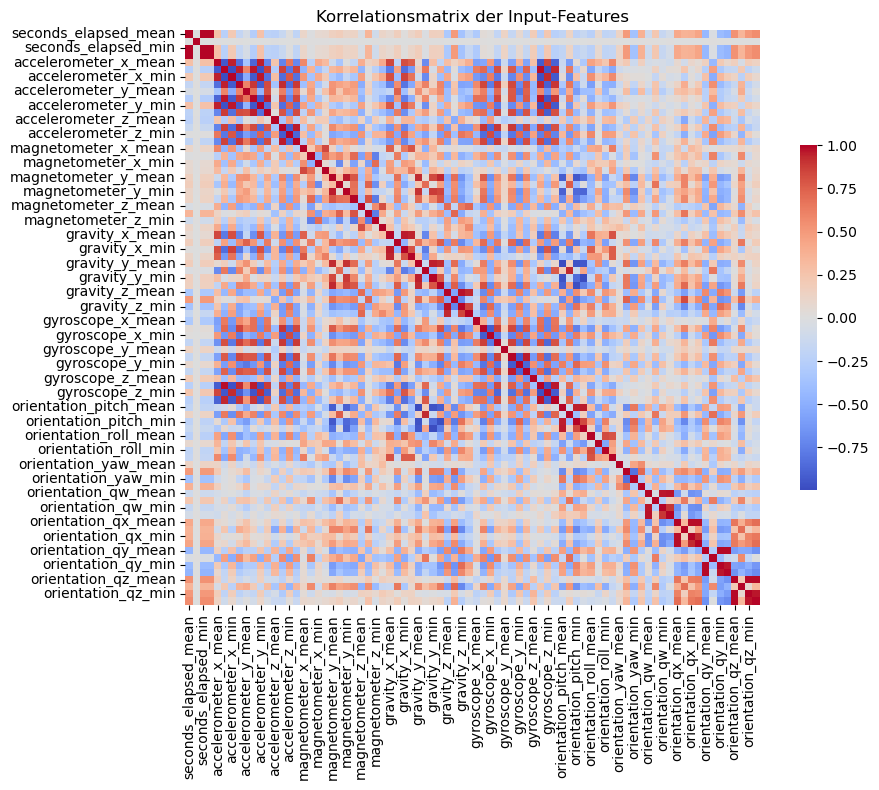

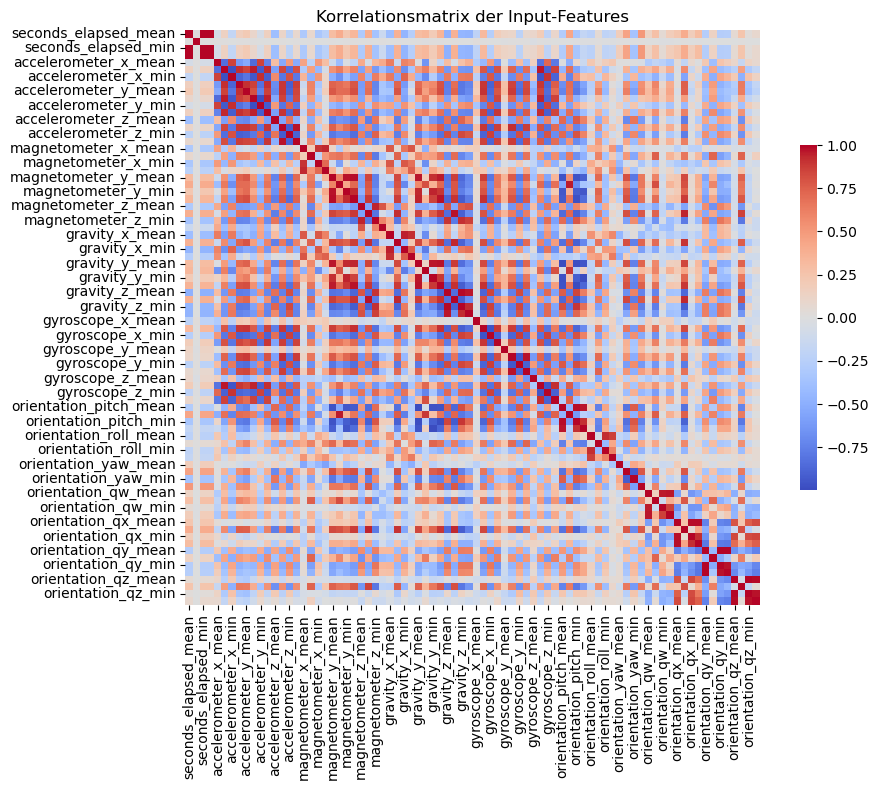

Pearson Korrelationskoeffizient zwischen den Matrizen: 0.9
Fehlende Werte pro Spalte in Train:


Series([], dtype: int64)

Fehlende Werte pro Spalte in Test:


Series([], dtype: int64)

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

# Überblick über die Zielklassen
print("Verteilung der Zielklassen in Train:")
display(y_train.value_counts(normalize=True).rename("Anteil").to_frame())

print("Verteilung der Zielklassen in Test:")
display(y_test.value_counts(normalize=True).rename("Anteil").to_frame())

# Grundlegende Statistik der Features in Train
display(X_train.describe().T)

# Grundlegende Statistik der Features in Test
display(X_test.describe().T)

# Korrelation der Features (stark korrelierte Features identifizieren) - Train
plt.figure(figsize=(10, 8))
corr_matrix_train = X_train.corr()
sns.heatmap(corr_matrix_train, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .6})
plt.title("Korrelationsmatrix der Input-Features")
plt.tight_layout()
plt.show();

# Korrelation der Features (stark korrelierte Features identifizieren)- Test
plt.figure(figsize=(10, 8))
corr_matrix_test = X_test.corr()
sns.heatmap(corr_matrix_test, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .6})
plt.title("Korrelationsmatrix der Input-Features")
plt.tight_layout()
plt.show();

# Ähnlichkeiten von den beiden Matrizen
correlation_coefficient = np.corrcoef(corr_matrix_train.values.flatten(), corr_matrix_test.values.flatten())[0, 1]

print(f"Pearson Korrelationskoeffizient zwischen den Matrizen: {correlation_coefficient:.2}")

# Prüfung auf fehlende Werte in Train
missing = df_train.isnull().sum()
print("Fehlende Werte pro Spalte in Train:")
display(missing[missing > 0])

# Prüfung auf fehlende Werte in Test
missing = df_test.isnull().sum()
print("Fehlende Werte pro Spalte in Test:")
display(missing[missing > 0])

#### Resultate der Datenexploration

Die Zielverteilung zeigt eine deutliche Klassenunbalance: Die Aktivität *climbing* ist mit knapp 39 % der Samples überrepräsentiert, während *walking*, *sitting* und *joggen* jeweils etwa gleich häufig auftreten (jeweils ~19–21 %). Diese Ungleichverteilung sollte bei der späteren Modellbewertung berücksichtigt werden, etwa durch gewichtete Metriken oder Ausgleichsverfahren.

Die deskriptive Statistik der Features weist auf eine erhebliche Streuung und unterschiedliche Skalenbereiche hin. Besonders auffällig sind die hohen Varianzen bei Zeitmerkmalen sowie stark unterschiedliche Wertebereiche bei Sensorachsen (Beschleunigung, Orientierung, etc.). Dies unterstreicht die Notwendigkeit einer Standardisierung vor dem Modelltraining.

Die Korrelationsanalyse zeigt starke lineare Zusammenhänge zwischen vielen Merkmalen, insbesondere innerhalb von Sensorgruppen (z. B. `accelerometer_*`, `gyroscope_*`, `orientation_*`). Diese Multikollinearität spricht für eine nachgelagerte Dimensionsreduktion, um Redundanzen zu vermeiden und die Lernalgorithmen zu entlasten.

Fehlende Werte wurden im Datensatz keine festgestellt, sodass keine Imputationsschritte erforderlich sind.

#### Teil 1.3 Hauptkomponentenanalyse (PCA)

Um die hohe Dimensionalität und Multikollinearität der sensorbasierten Eingabedaten zu adressieren, wurde eine Hauptkomponentenanalyse (PCA) durchgeführt. Ziel war es, eine kompaktere Repräsentation der Daten zu finden, die dennoch den Großteil der erklärbaren Varianz beibehält. Eine solche Reduktion hilft, das Overfitting-Risiko zu senken, die Rechenzeit zu reduzieren und die Robustheit der nachfolgenden Klassifikationsmodelle zu erhöhen.

Die PCA wurde auf den standardisierten Trainingsdaten angewendet. Als Kriterium für die Beibehaltung von Hauptkomponenten wurde eine kumulierte erklärte Varianz von mindestens 95 % definiert.

Totale ursprüngliche Features : 80
Reduziert auf Hauptkomponenten: 18
Erklärte Varianz durch PCA    : 0.9506


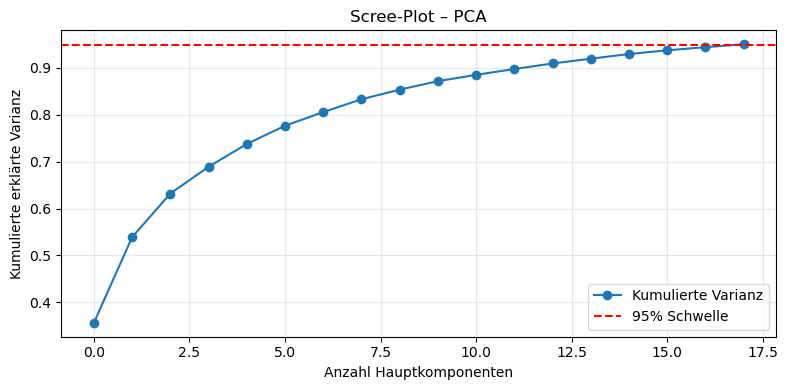

In [225]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Daten skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. PCA mit Varianz-Schwelle
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Informationen zur Reduktion
total_features = X_train.shape[1]
retained_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Totale ursprüngliche Features : {total_features}")
print(f"Reduziert auf Hauptkomponenten: {retained_components}")
print(f"Erklärte Varianz durch PCA    : {explained_variance:.4f}")

# 4. Scree-Plot (kumulative erklärte Varianz)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='Kumulierte Varianz')
plt.axhline(0.95, color='red', linestyle='--', label='95% Schwelle')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Scree-Plot – PCA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [226]:
import pandas as pd

# Ladungsmatrix: 
loadings = pd.DataFrame(
    pca.components_,                # shape: (n_components, n_features)
    columns=X_train.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Absolutwerte zur Bewertung des Einflusses (je höher, desto mehr Einfluss)
abs_loadings = loadings.abs()

# Gesamtbeitrag jedes ursprünglichen Features über alle PCs aufsummieren
total_feature_contribution = abs_loadings.sum(axis=0).sort_values(ascending=False)

top_19_original_features = total_feature_contribution.head(19)
print("---Top 19 Originalfeatures mit grösstem Einfluss auf PCA---")
print(top_19_original_features)

---Top 19 Originalfeatures mit grösstem Einfluss auf PCA---
gyroscope_y_mean         2.889928
gyroscope_z_mean         2.463933
accelerometer_z_mean     2.348854
orientation_yaw_mean     2.171900
orientation_roll_std     2.104879
orientation_roll_min     2.071607
magnetometer_z_max       1.971879
orientation_yaw_min      1.960769
gravity_z_max            1.943859
orientation_roll_mean    1.861009
magnetometer_z_mean      1.846000
gyroscope_x_mean         1.843449
orientation_roll_max     1.833678
orientation_yaw_max      1.829462
seconds_elapsed_min      1.792994
seconds_elapsed_mean     1.792993
seconds_elapsed_max      1.792992
orientation_yaw_std      1.764307
orientation_qw_std       1.719306
dtype: float64


#### Ergebnisse der PCA

Die Scree-Plot-Analyse zeigt, dass **bereits 18 Hauptkomponenten ausreichen**, um **95,6 % der Gesamtvarianz** des ursprünglichen 80-dimensionalen Merkmalsraums zu erklären. Dies entspricht einer effektiven Reduktion auf weniger als ein Viertel der Ursprungsdimension, bei gleichzeitig minimalem Informationsverlust.

Die einflussreichsten Originalmerkmale auf die Hauptkomponenten stammen aus folgenden Sensoren:

- **Gyroskop**: `gyroscope_y_mean`, `gyroscope_z_mean`, `gyroscope_x_mean`
- **Beschleunigung**: `accelerometer_z_mean`
- **Orientierung**: `orientation_roll_std`, `orientation_roll_min`, `orientation_roll_max`
- **Magnetometer**: `magnetometer_z_max`, `magnetometer_x_max`, `magnetometer_x_min`
- **Zeitmerkmale**: `seconds_elapsed_max`, `seconds_elapsed_mean`, `seconds_elapsed_min`

Diese Merkmale zeigen besonders starke Projektionen in den Hauptkomponenten und sind somit wesentlich für die Unterscheidung der Aktivitätsklassen. Die Kombination aus Zeit-, Bewegungs- und Lageinformationen scheint entscheidend für die Klassifikationsleistung zu sein.

Diese reduzierten Dimensionen werden im weiteren Verlauf der Analyse als Input für die Klassifikationsmodelle verwendet.

### Teil 2 Klassischer Machine-Learning-Modelle


In diesem Teil des Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten eingesetzt, um menschliche Aktivitäten zu klassifizieren – konkret: Gehen (walk), Laufen (run), Sitzen (sitting) und Bergaufgehen (climbing).

Die untersuchten Algorithmen sind:

* Random Forest
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Ziel der Analyse ist es, die drei Modelle anhand etablierter Leistungskennzahlen – Accuracy, Precision, Recall und F1-Score – systematisch zu vergleichen und dabei eine Klassifikationsgenauigkeit von mindestens 90 % zu erreichen.

Für alle drei Machine-Learning-Modelle wurde ein einheitliches Modellierungsframework verwendet. Die Modellarchitektur basiert jeweils auf einer Pipeline, die folgende Schritte umfasst:

* **Standardisierung** der Eingabedaten mit `StandardScaler`.
* **Dimensionsreduktion** mittels PCA (95 % erklärte Varianz - wird für Random Forrest ausgelassen).
* **Klassifikation** mit dem jeweiligen Algorithmus (RF, SVM oder KNN).
 
Zur Modelloptimierung wurde für alle Modelle eine **GridSearchCV** mit 5-facher Kreuzvalidierung verwendet. Dabei wurde gezielt der `accuracy`-Score als Optimierungskriterium herangezogen. Die einheitliche Vorgehensweise ermöglicht einen fairen und nachvollziehbaren Vergleich der Modellleistungen.

Darüber hinaus wird ein **Modellvergleichstracker** eingerichtet, der für jedes Klassifikationsmodell die zentralen Leistungskennzahlen – Accuracy, Precision (macro), Recall (macro) und F1-Score (macro) – sowohl für Trainings- als auch Testdaten systematisch speichert. 

Die Verwendung des *macro*-Durchschnitts ist besonders geeignet, da er für jede Klasse den jeweiligen Metrikwert berechnet und anschließend den arithmetischen Mittelwert über alle Klassen bildet – unabhängig von deren Häufigkeit. Dies gewährleistet, dass auch seltener vertretene Klassen (wie z. B. „joggen“) gleichwertig in die Bewertung einfliessen. Ein *macro*-basierter Vergleich ist somit fairer und informativer in Fällen mit Klassenungleichgewicht, wie es auch im vorliegenden Datensatz zu beobachten ist.

Der Tracker ermöglicht am Ende eine konsistente und transparente Gegenüberstellung aller Modelle auf Basis einheitlicher Bewertungsmaßstäbe und bildet die Grundlage für eine fundierte Auswahl des besten Klassifikators.


In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# Modellvergleichs-Tracker initialisieren
model_metrics = []

# Funktion zur Speicherung von Metriken
def store_model_metrics(name, train_acc, train_prec, train_rec, train_f1, test_acc, test_prec, test_rec, test_f1):
    model_metrics.append(OrderedDict({
        'Modell': name,
        'Train Accuracy': train_acc,
        'Train Precision': train_prec,
        'Train Recall': train_rec,
        'Train F1-Score': train_f1,
        'Test Accuracy': test_acc,
        'Test Precision': test_prec,
        'Test Recall': test_rec,
        'Test F1-Score': test_f1
    }))

# Funktion zur standardisierten Modell-Evaluation
def evaluate_model(name, best_model, X_train, y_train, X_test, y_test):
    # Falls LabelEncoder verwendet wurde, zurücktransformieren
    if isinstance(y_train[0], (int, np.integer)) and hasattr(evaluate_model, 'label_encoder'):
        le = evaluate_model.label_encoder
        y_train = le.inverse_transform(y_train)
        y_test = le.inverse_transform(y_test)
        y_train_pred = le.inverse_transform(best_model.predict(X_train))
        y_test_pred = le.inverse_transform(best_model.predict(X_test))
    else:
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

    # Klassenlabels für Achsenbeschriftungen
    class_labels = sorted(list(set(y_train) | set(y_test)))

    # Trainingsmetriken
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    recall_train = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    f1_train = f1_score(y_train, y_train_pred, average='macro', zero_division=0)

    print("\n--- Metriken auf Traindaten ---")
    print(f"Accuracy : {accuracy_train:.4f}")
    print(f"Precision: {precision_train:.4f}")
    print(f"Recall   : {recall_train:.4f}")
    print(f"F1-Score : {f1_train:.4f}")

    # Konfusionsmatrix: Train
    cm_train = confusion_matrix(y_train, y_train_pred, labels=class_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Konfusionsmatrix – Trainingsdaten ({name})')
    plt.xlabel('Vorhergesagt')
    plt.ylabel('Tatsächlich')
    plt.tight_layout()
    plt.show()

    # Testmetriken
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    recall_test = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1_test = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    print("\n--- Metriken auf Testdaten ---")
    print(f"Accuracy : {accuracy_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Recall   : {recall_test:.4f}")
    print(f"F1-Score : {f1_test:.4f}")

    # Konfusionsmatrix: Test
    cm_test = confusion_matrix(y_test, y_test_pred, labels=class_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Konfusionsmatrix – Testdaten ({name})')
    plt.xlabel('Vorhergesagt')
    plt.ylabel('Tatsächlich')
    plt.tight_layout()
    plt.show()

    utils.plot_learning_curve(
        estimator=best_model,
        X=X_train,    
        y=y_train,
        cv=5, 
        scoring="accuracy",
        title=f"Lernkurve – {name}"
    )

    # Speichern der Ergebnisse
    store_model_metrics(
        name,
        train_acc=accuracy_train,
        train_prec=precision_train,
        train_rec=recall_train,
        train_f1=f1_train,
        test_acc=accuracy_test,
        test_prec=precision_test,
        test_rec=recall_test,
        test_f1=f1_test
    )


### Random Forest

Random Forest ist ein leistungsfähiges Ensembleverfahren, das eine Vielzahl an Entscheidungsbäumen kombiniert, um robuste Vorhersagen zu treffen. Für jeden Baum werden zufällig Subsets von Features und Beobachtungen gezogen (Bagging-Prinzip), wodurch Varianz reduziert und Overfitting vorgebeugt wird. Aufgrund dieser Eigenschaften ist das Modell besonders geeignet für hochdimensionale und verrauschte Datensätze wie Sensordaten.

Random Forests sind weitgehend unempfindlich gegenüber Multikollinearität und benötigen keine explizite Normierung oder Dimensionsreduktion - Deswegen wird hier der PCA nicht eingesetzt.



Fitting 5 folds for each of 24 candidates, totalling 120 fits


Bester CV-Score (Accuracy): 0.9483
Bestes Modell: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=3, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

--- Metriken auf Traindaten ---
Accuracy : 0.9868
Precision: 0.9863
Recall   : 0.9887
F1-Score : 0.9873


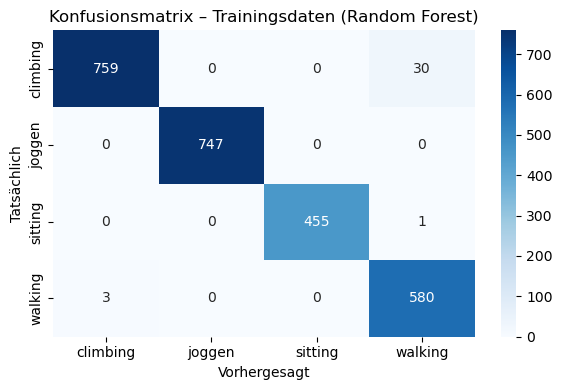


--- Metriken auf Testdaten ---
Accuracy : 0.9839
Precision: 0.9801
Recall   : 0.9923
F1-Score : 0.9857


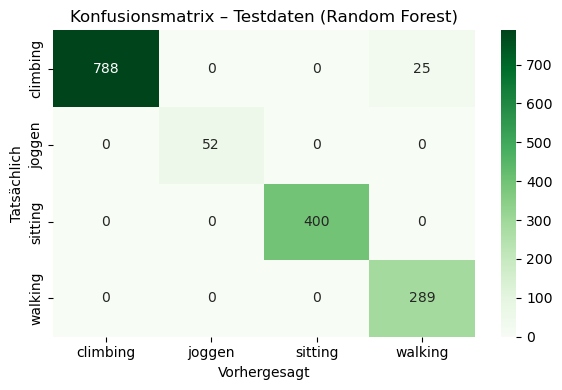

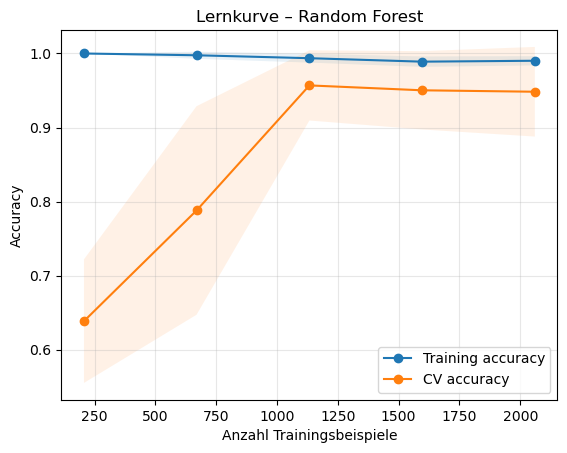

          Modell  Train Accuracy  Train Precision  Train Recall  \
0  Random Forest        0.986796         0.986332       0.98866   

   Train F1-Score  Test Accuracy  Test Precision  Test Recall  Test F1-Score  
0        0.987287       0.983912        0.980096     0.992312       0.985731  


In [228]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', RandomForestClassifier(random_state=42))
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für GridSearchCV
param_grid_rf = {
    'clf__n_estimators': [100, 200],    # Anzahl der Bäume
    'clf__max_depth': [None, 3, 5, 7, 9, 11],   # Maximale Baumtiefe
    'clf__min_samples_split': [2, 5]    # Min. Samples zum Split
}

# ---------------------------------------------------------------------------
# GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training auf Trainingsdaten
grid_rf.fit(X_train, y_train)

# Beste Parameter und CV-Score ausgeben
print(f"Bester CV-Score (Accuracy): {grid_rf.best_score_:.4f}")

# ---------------------------------------------------------------------------
# Vorhersage auf Testdaten & Trainingsdaten
y_train_pred = grid_rf.predict(X_train)
y_test_pred = grid_rf.predict(X_test)

# Bestes Modell extrahieren
best_model = grid_rf.best_estimator_
print(f"Bestes Modell: {best_model}")

# Evaluation und Speichern der Ergebnisse
evaluate_model("Random Forest", best_model, X_train, y_train, X_test, y_test)

model_metrics_df = pd.DataFrame(model_metrics)
print(model_metrics_df.head())



### Support Vector Machine (SVM)

Support Vector Machines zielen darauf ab, optimale Trennflächen im Merkmalsraum zu finden, die die Trainingsdaten mit maximalem Abstand (Margin) zwischen den Klassen separieren. Besonders in hochdimensionalen Räumen zeigen SVMs oft sehr gute Generalisierungseigenschaften. Dies macht sie zu einem attraktiven Kandidaten für klassifikatorische Aufgaben auf komplexen Sensordaten.

Da SVMs empfindlich auf die Skalierung der Daten und auf redundante Features reagieren, ist eine vorgelagerte Standardisierung und PCA-Dimensionreduktion hier essenziell. Dies stellt sicher, dass die Distanzen im Raum sinnvoll interpretiert werden können.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Beste Parameter: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Bester CV-Score (Accuracy): 0.9351

--- Metriken auf Traindaten ---
Accuracy : 0.9926
Precision: 0.9932
Recall   : 0.9926
F1-Score : 0.9929


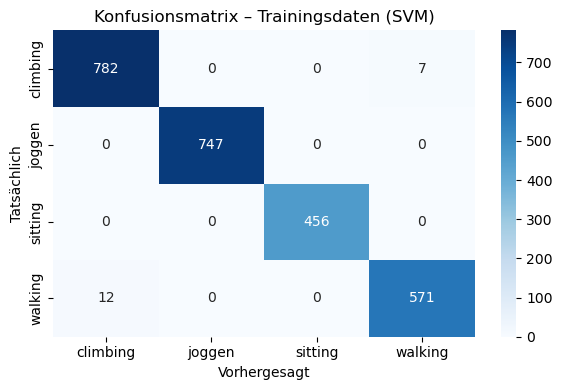


--- Metriken auf Testdaten ---
Accuracy : 0.9949
Precision: 0.9948
Recall   : 0.9959
F1-Score : 0.9953


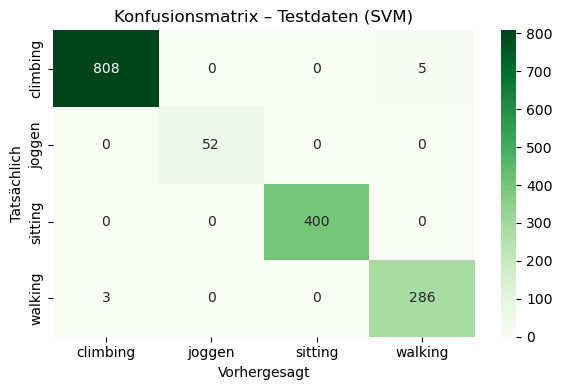

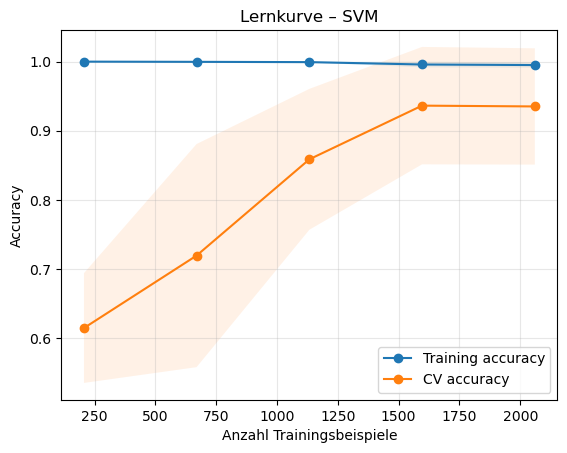

In [229]:
from sklearn.svm import SVC

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + PCA + SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('clf', SVC(probability=True))
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für GridSearchCV
param_grid_svm = {
    'clf__C': [0.1, 1, 10],          # Regularisierungsparameter
    'clf__kernel': ['rbf', 'linear'],# Kernel-Typ
    'clf__gamma': ['scale', 'auto']  # Gamma für rbf-Kernel
}

# ---------------------------------------------------------------------------
# GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training auf Trainingsdaten
grid_svm.fit(X_train, y_train)
print("Beste Parameter:", grid_svm.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_svm.best_score_:.4f}")

# ---------------------------------------------------------------------------
# Vorhersage auf Testdaten & Trainingsdaten
y_train_pred = grid_svm.predict(X_train)
y_test_pred = grid_svm.predict(X_test)

# Bestes Modell extrahieren
best_model = grid_svm.best_estimator_

# Evaluation und Speichern der Ergebnisse
evaluate_model("SVM", best_model, X_train, y_train, X_test, y_test)


### K-Nearest Neighbors (KNN)

Das K-Nearest-Neighbors-Verfahren ist ein einfaches, aber wirkungsvolles instanzbasiertes Modell. Es klassifiziert neue Beobachtungen basierend auf den *k* nächstgelegenen Trainingspunkten im Merkmalsraum. Trotz seiner Einfachheit kann KNN bei sauber strukturierten Datensätzen überzeugende Resultate liefern.

KNN reagiert jedoch empfindlich auf hohe Dimensionalität (Stichwort: Curse of Dimensionality). Aus diesem Grund ist eine PCA-Verdichtung der Feature-Räume unabdingbar, um sinnvolle Nachbarschaften zu erhalten. Die Wahl des Parameters *k* sowie des Distanzmaßes erfolgt über systematische GridSearchCV-Abstimmung.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Beste Parameter: {'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
Bester CV-Score (Accuracy): 0.9122

--- Metriken auf Traindaten ---
Accuracy : 0.9969
Precision: 0.9971
Recall   : 0.9967
F1-Score : 0.9969


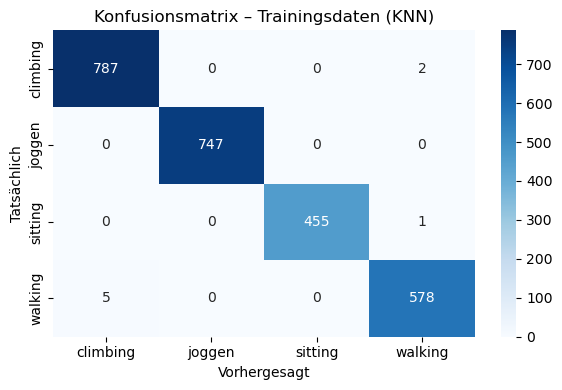


--- Metriken auf Testdaten ---
Accuracy : 0.7394
Precision: 0.8039
Recall   : 0.8448
F1-Score : 0.7971


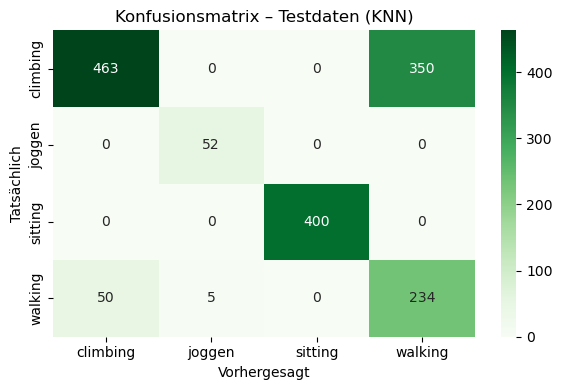

/opt/miniconda3/envs/cdl1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/envs/cdl1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/miniconda3/envs/cdl1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/miniconda3/envs/cdl1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/opt/miniconda3/envs/cdl1/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/opt/miniconda3/envs/cdl1/lib/python3.10/site-packages/skl

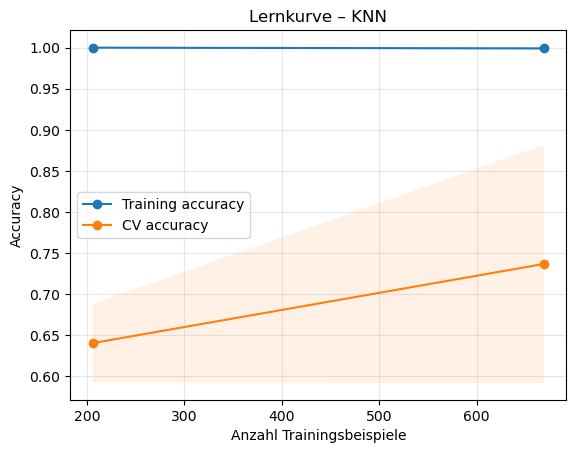

In [230]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------------------------
# Zielvariablen kodieren (String → Integer)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# LabelEncoder an evaluate_model übergeben
evaluate_model.label_encoder = le

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + PCA + KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('clf', KNeighborsClassifier())
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für KNN
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
}

# ---------------------------------------------------------------------------
# GridSearchCV
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training
grid_knn.fit(X_train, y_train_enc)
print("Beste Parameter:", grid_knn.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_knn.best_score_:.4f}")

# Bestes Modell extrahieren
best_model = grid_knn.best_estimator_

# Evaluation und Speichern der Ergebnisse
evaluate_model("KNN", best_model, X_train, y_train_enc, X_test, y_test_enc)